In [1]:
import os
import numpy as np
from astropy.io import fits
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib notebook

import tel_tools
from mmrs_xytoabl import mmrs_xytoabl
from mmrs_abtov2v3 import mmrs_abtov2v3

In [2]:
# define inputs
obs_type = 'cv'
band = '1A'
if band == '1A':
    obs_file = '/Users/ioannisa/Desktop/python/miri_devel/CV2_data/LVL2/processed/MIRM0363-P0-SHORT-4230014759_1_495_SE_2014-08-18T02h00m43_LVL2.fits'
elif band == '1B':
    obs_file = '/Users/ioannisa/Desktop/python/miri_devel/CV2_data/LVL2/processed/MIRM0363-P0-MED-4230061457_1_495_SE_2014-08-18T06h27m37_LVL2.fits'
elif band == '1C':
    obs_file = '/Users/ioannisa/Desktop/python/miri_devel/CV2_data/LVL2/processed/MIRM0363-P0-LONG-4230100846_1_495_SE_2014-08-18T10h28m39_LVL2.fits'
islice=200
wtype=2
plot_distortion = False
write_fits_file = False

In [3]:
# define functions
def twoD_Gaussian_ravel( xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x,y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                            + c*((y-yo)**2)))
    return g.ravel()

def twoD_Gaussian_noravel( xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset ):
    x,y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                            + c*((y-yo)**2)))
    return g

In [4]:
# in/out file paths
indir = os.path.dirname(os.path.realpath(obs_file))

outdir=indir+'/stack/'

if write_fits_file:
    if os.path.exists(outdir) is False:
        os.system('mkdir {}'.format(outdir))
outcube=outdir+'cube.fits'
outslice=outdir+'slice.fits'
outcollapse=outdir+'collapse.fits'

In [5]:
# header information
hdu0=fits.open(obs_file)[0].header
hdu1=fits.open(obs_file)[1].header
thisdet=hdu0['DETECTOR'] # MIRIFUSHORT or MIRIFULONG

# CV data use DGAA_POS and DGAB_POS
if (obs_type == 'cv'):
    thisband=hdu0['DGAA_POS'] # Assume no crossed-setups.  SHORT,MEDIUM,LONG
# mirisim data use BAND
if (obs_type == 'mirisim'):
    thisband=hdu0['BAND']

# position
raref= hdu0['RA_REF']
decref= hdu0['DEC_REF']
v2ref= hdu0['V2_REF']
v3ref= hdu0['V3_REF']
rollref= hdu0['ROLL_REF']

ny = hdu1['NAXIS2']

# Band-specific information about pixel/slice size
# and cube-building parameters
if band[0] == '1':
    pwidth=0.196 # pixel size along alpha in arcsec
    swidth=0.176 # slice width in arcsec
    xmin = 8 # Minimum x pixel
    xmax = 509 # Maximum x pixel

    # Output cube parameters
    rlim_arcsec=0.1 # in arcseconds
    rlimz_mic=0.0025
    ps_x=0.13 # arcsec
    ps_y=0.13 # arcsec
    ps_z=0.0025 # micron

elif band[0] == '2':
    pwidth=0.196 # pixel size along alpha in arcsec
    swidth=0.277 # slice width in arcsec
    xmin=520 # Minimum x pixel
    xmax=1020 # Maximum x pixel

    # Output cube parameters
    rlim_arcsec=0.1 # in arcseconds
    rlimz_mic=0.004
    ps_x=0.13 # arcsec
    ps_y=0.13 # arcsec
    ps_z=0.004 # micron

elif band[0] == '3':
    pwidth=0.245 # pixel size along alpha in arcsec
    swidth=0.387 # slice width in arcsec
    xmin=510 # Minimum x pixel
    xmax=1025 # Maximum x pixel

    # Output cube parameters
    rlim_arcsec=0.1 # in arcseconds
    rlimz_mic=0.004
    ps_x=0.1 # arcsec
    ps_y=0.1 # arcsec
    ps_z=0.002 # micron

elif band[0] == '4':
    pwidth=0.273 # pixel size along alpha in arcsec
    swidth=0.645 # slice width in arcsec
    xmin=14 # Minimum x pixel
    xmax=480 # Maximum x pixel

    # Output cube parameters
    rlim_arcsec=0.4 # in arcseconds
    rlimz_mic=0.004
    ps_x=0.2 # arcsec
    ps_y=0.2 # arcsec
    ps_z=0.002 # micron

# Ramps data are not pixel area corrected, while Lvl2b
# data are
parea=1.0 # pixel area

In [6]:
# Define 0-indexed base x and y pixel number
basex,basey = np.meshgrid(np.arange(1032),np.arange(1024))
# Convert to base alpha,beta,lambda
basealpha,basebeta,baselambda,slicenum = mmrs_xytoabl(band)

if plot_distortion:
    fig,axs=plt.subplots(1,4,figsize=(11,3))
    plt.suptitle('Distortion maps')
    axs[0].imshow(basealpha)
    axs[0].set_title('alpha')
    axs[1].imshow(basebeta)
    axs[1].set_title('beta')
    axs[2].imshow(baselambda)
    axs[2].set_title('lambda')
    axs[3].imshow(slicenum)
    axs[3].set_title('slice map')
    plt.tight_layout()

basex = basex[:,xmin:xmax]
basey = basey[:,xmin:xmax]
basealpha = basealpha[:,xmin:xmax]
basebeta = basebeta[:,xmin:xmax]
baselambda = baselambda[:,xmin:xmax]
slicenum = slicenum[:,xmin:xmax]

if plot_distortion:
    fig,axs=plt.subplots(1,4,figsize=(11,3))
    plt.suptitle('Cropped to band {}'.format(band))
    axs[0].imshow(basealpha)
    axs[0].set_title('alpha')
    axs[1].imshow(basebeta)
    axs[1].set_title('beta')
    axs[2].imshow(baselambda)
    axs[2].set_title('lambda')
    axs[3].imshow(slicenum)
    axs[3].set_title('slice map')
    plt.tight_layout()

    # Convert all alpha,beta base locations to v2,v3 base locations
    basev2,basev3,xan,yan = mmrs_abtov2v3(basealpha,basebeta,band)
    ra,dec,newroll = tel_tools.jwst_v2v3toradec(basev2.ravel(),basev3.ravel(),hdr=hdu0)

    fig,axs=plt.subplots(1,4,figsize=(11,3))
    axs[0].imshow(basev2)
    axs[0].set_title('V2')
    axs[1].imshow(basev3)
    axs[1].set_title('V3')
    axs[2].imshow(xan)
    axs[2].set_title('XAN')
    axs[3].imshow(yan)
    axs[3].set_title('YAN')
    plt.tight_layout()

    fig,axs=plt.subplots(1,3,figsize=(11,3))
    axs[0].imshow(ra.reshape(basev2.shape))
    axs[0].set_title('RA')
    axs[1].imshow(dec.reshape(basev2.shape))
    axs[1].set_title('DEC')
    axs[2].imshow(newroll.reshape(basev2.shape))
    axs[2].set_title('ROLL')
    plt.tight_layout()

# Crop to only pixels on a real slice
index0=np.where(slicenum > 0)
dummy = slicenum.copy()
slicenum=slicenum[index0]
basex=basex[index0]
basey=basey[index0]
basebeta=basebeta[index0]
basealpha=basealpha[index0]
baselambda=baselambda[index0]
npix=len(slicenum)

# 1d conversion
basev2,basev3,xan,yan = mmrs_abtov2v3(basealpha,basebeta,band)
# Coordinate transform
ra,dec,newroll = tel_tools.jwst_v2v3toradec(basev2,basev3,hdr=hdu0)

In [7]:
# Create a master vector of fluxes and v2,v3 locations
nfiles = 1
i = 0 # indexing number of observation files, in this case it's just one file
master_flux=np.zeros(npix*nfiles)
master_ra=np.zeros(npix*nfiles)
master_dec=np.zeros(npix*nfiles)
master_lam=np.zeros(npix*nfiles)
master_expnum=np.zeros(npix*nfiles)
master_dq=np.zeros(npix*nfiles)
# Extra vectors for debugging
master_detx=np.zeros(npix*nfiles) # 0-indexed
master_dety=np.zeros(npix*nfiles) # 0-indexed
master_v2=np.zeros(npix*nfiles)
master_v3=np.zeros(npix*nfiles)

# Save values
master_ra[i*npix:(i+1)*npix]=ra
master_dec[i*npix:(i+1)*npix]=dec
master_lam[i*npix:(i+1)*npix]=baselambda
master_expnum[i*npix:(i+1)*npix]=i
master_detx[i*npix:(i+1)*npix]=basex
master_dety[i*npix:(i+1)*npix]=basey
master_v2[i*npix:(i+1)*npix]=basev2
master_v3[i*npix:(i+1)*npix]=basev3

<IPython.core.display.Javascript object>


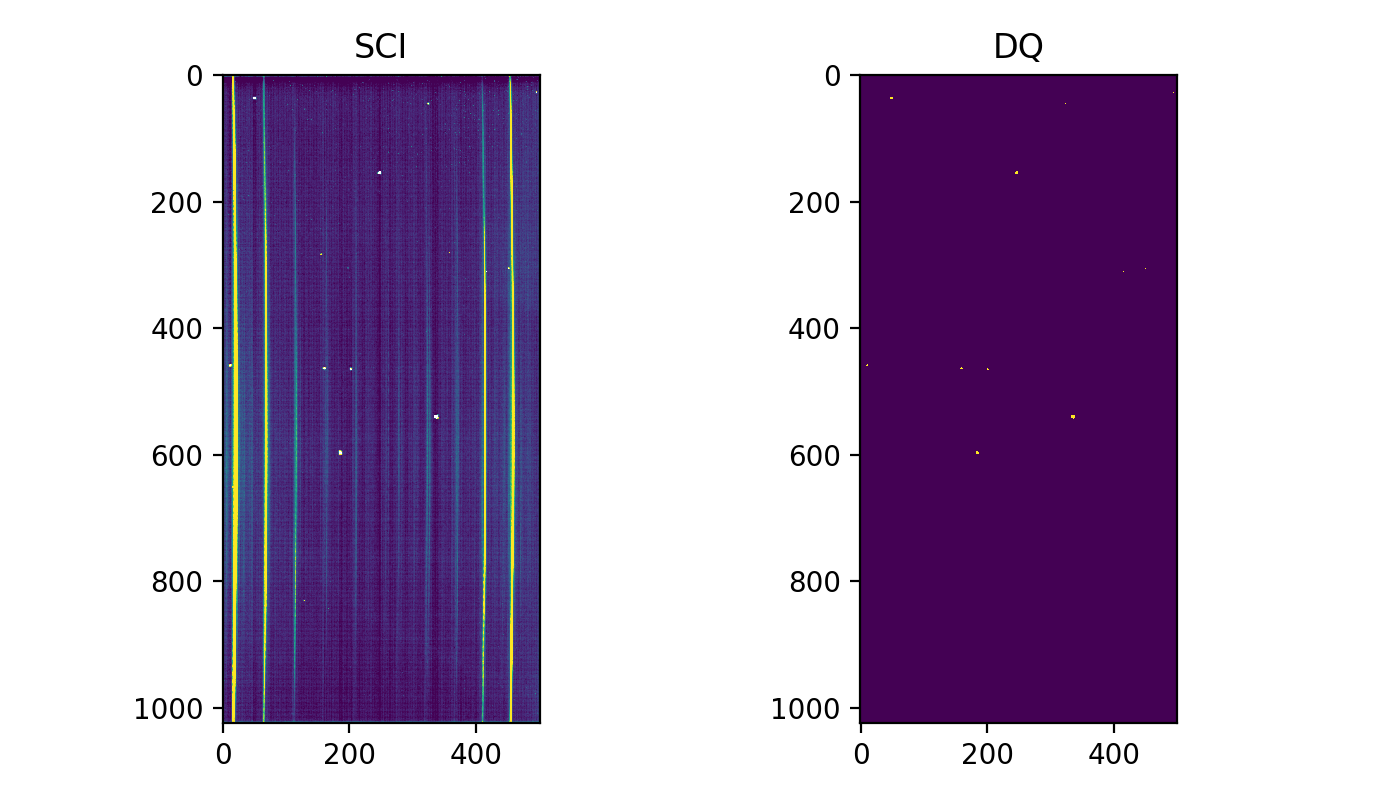

In [8]:
# Loop over input files reading them into master vectors
hdulist = fits.open(obs_file)

thisimg=hdulist[0].data[0,:,:]
thisdq=hdulist[0].data[2,:,:]

# If dimensionality is not 2, something went wrong
if (len(thisimg.shape) != 2):
    raise KeyError('Error: wrong input file dimensions, is this ramp data?')

# Crop to correct 1/2 of detector
thisflux=thisimg[:,xmin:xmax]
thisdq=thisdq[:,xmin:xmax]

fig,axs=plt.subplots(1,2,figsize=(7,4))
axs[0].imshow(thisflux,vmin=0,vmax=1)
axs[0].set_title('SCI')
axs[1].imshow(thisdq)
axs[1].set_title('DQ')
plt.tight_layout()

# Crop to only pixels on real slices
thisflux=thisflux[index0]
thisdq=thisdq[index0]

master_flux[i*npix:(i+1)*npix]=thisflux
master_dq[i*npix:(i+1)*npix]=thisdq

In [9]:
# Crop any pixels with bad DQ flags
good=np.where(master_dq == 0)
master_flux=master_flux[good]
master_ra=master_ra[good]
master_dec=master_dec[good]
master_lam=master_lam[good]
master_expnum=master_expnum[good]
master_dq=master_dq[good]
master_detx=master_detx[good]
master_dety=master_dety[good]
master_v2=master_v2[good]
master_v3=master_v3[good]

# Trim to eliminate any nan fluxes
index1 = ~np.isnan(master_flux)
master_flux=master_flux[index1]
master_ra=master_ra[index1]
master_dec=master_dec[index1]
master_lam=master_lam[index1]
master_expnum=master_expnum[index1]
master_dq=master_dq[index1]
master_detx=master_detx[index1]
master_dety=master_dety[index1]
master_v2=master_v2[index1]
master_v3=master_v3[index1]

In [10]:
# Safety case deal with 0-360 range to ensure no problems
# around ra=0 with coordinate wraparound
medra=np.median(master_ra)
wrapind=np.where(abs(master_ra - medra) > 180.)
nwrap = len(wrapind[0])
if ((nwrap != 0) & (medra < 180.)):
    master_ra[wrapind] = master_ra[wrapind]-360.
if ((nwrap != 0) & (medra >= 180.)):
    master_ra[wrapind] = master_ra[wrapind]+360.

In [11]:
# Declare maxima/minima of the cube range *before* doing any QA cuts for specific exposures
lmin=min(master_lam)
lmax=max(master_lam)
ra_min=min(master_ra)
ra_max=max(master_ra)
dec_min=min(master_dec)
dec_max=max(master_dec)
dec_ave=(dec_min+dec_max)/2.
ra_ave=(ra_min+ra_max)/2.

print('Wavelength limits: {} - {} micron'.format(round(lmin,2),round(lmax,2)))
print('RA limits: {} - {} deg'.format(round(ra_min,4),round(ra_max,4)))
print('DEC limits: {} - {} deg'.format(round(dec_min,4),round(dec_max,4)))

Wavelength limits: 4.85 - 5.77 micron
RA limits: 44.9994 - 45.0005 deg
DEC limits: -0.0005 - 0.0006 deg


In [12]:
# Tangent plane projection to xi/eta (spatial axes)
xi_min=3600.*(ra_min-ra_ave)*np.cos(dec_ave*np.pi/180.)
xi_max=3600.*(ra_max-ra_ave)*np.cos(dec_ave*np.pi/180.)
eta_min=3600.*(dec_min-dec_ave)
eta_max=3600.*(dec_max-dec_ave)

# Define cube sizes
n1a=np.ceil(abs(xi_min)/ps_x)
n1b=np.ceil(abs(xi_max)/ps_x)
n2a=np.ceil(abs(eta_min)/ps_y)
n2b=np.ceil(abs(eta_max)/ps_y)
cube_xsize=int(n1a+n1b)
cube_ysize=int(n2a+n2b)

# Redefine xi/eta minima/maxima to exactly
# match pixel boundaries
xi_min = -n1a*ps_x - ps_x/2.
xi_max = n1b*ps_x + ps_x/2.
eta_min = -n2a*ps_y - ps_y/2.
eta_max = n2b*ps_y + ps_y/2.

print('XI limits: {} - {} deg'.format(round(xi_min,4),round(xi_max,4)))
print('ETA limits: {} - {} deg'.format(round(eta_min,4),round(eta_max,4)))

xi=3600.*(master_ra-ra_ave)*np.cos(dec_ave*np.pi/180.)
eta=3600.*(master_dec-dec_ave)
cube_x=(xi-xi_min-ps_x/2.)/ps_x
cube_y=(eta-eta_min-ps_y/2.)/ps_y

racen=ra_ave
decen=dec_ave
xcen=n1a
ycen=n2a

# Spectral axis
zrange=lmax-lmin
cube_zsize=int(np.ceil(zrange/ps_z))
lamcen=(lmax+lmin)/2.
lamstart=lamcen-(cube_zsize/2.)*ps_z
lamstop=lamstart+cube_zsize*ps_z
cube_z=(master_lam-lamstart)/ps_z # Z output cube location in pixels
wavevec=np.arange(cube_zsize)*ps_z+min(master_lam)

dim_out = [cube_xsize,cube_ysize,cube_zsize]
print('Cube X-Y-Z dimensions: {} spaxels'.format(dim_out))

XI limits: -2.145 - 2.145 deg
ETA limits: -2.145 - 2.145 deg
Cube X-Y-Z dimensions: [32, 32, 371] spaxels


In [13]:
# squash factors
xpsf_arcsec=0.3
ypsf_arcsec=0.24
zpsf_micron=1 # NOT DONE
xpsf=1. # 0.3 # xpsf_arcsec/ps_x
ypsf=1. # 0.24 # ypsf_arcsec/ps_y
xsquash=xpsf
ysquash=ypsf
zsquash=1.
# Note- arbitrarily squashing x and y too much effectively
# downranks the importance of the z distancedecreasing spectral
# resolution to improve spatial resolution.

# radius of influence
rlimx=rlim_arcsec/ps_x # in pixels
rlimy=rlimx # in pixels
rlimz=rlimz_mic/ps_z
# (Gives about 1-2 spec elements at each spatial element)
rlim=[2*rlimx,2*rlimy,rlimz] # in pixels
print('Radius of influence in X-Y-Z direction: {} pixels'.format(rlim))

# Scale correction factor is the ratio of area between an input pixel
# (in arcsec^2) and the output pixel size in arcsec^2
# The result means that the cube will be in calibrated units/pixel
# scale=ps_x*ps_y/(parea)
scale=1.0 # Output is in flux/solid angle

Radius of influence in X-Y-Z direction: [1.5384615384615385, 1.5384615384615385, 1.0] pixels


In [14]:
#> initialize cube-build
thisdim_out = list(dim_out)
# Output cubes
fcube=np.zeros(thisdim_out)
maskcube=np.ones(thisdim_out)

# XYZ output spaxel coordinate arrays
arr_xcoord = np.arange(thisdim_out[0])
arr_ycoord = np.arange(thisdim_out[1])
arr_zcoord = np.arange(thisdim_out[2])

if islice is not None:
    if ((islice >= 0) & (islice < thisdim_out[2])):
        thisdim_out[2]=1
        arr_zcoord=[islice]
        print('New cube dimensions: {}'.format(thisdim_out))
        print('Cube slice investigated: {}'.format(arr_zcoord))

New cube dimensions: [32, 32, 1]
Cube slice investigated: [200]


<IPython.core.display.Javascript object>


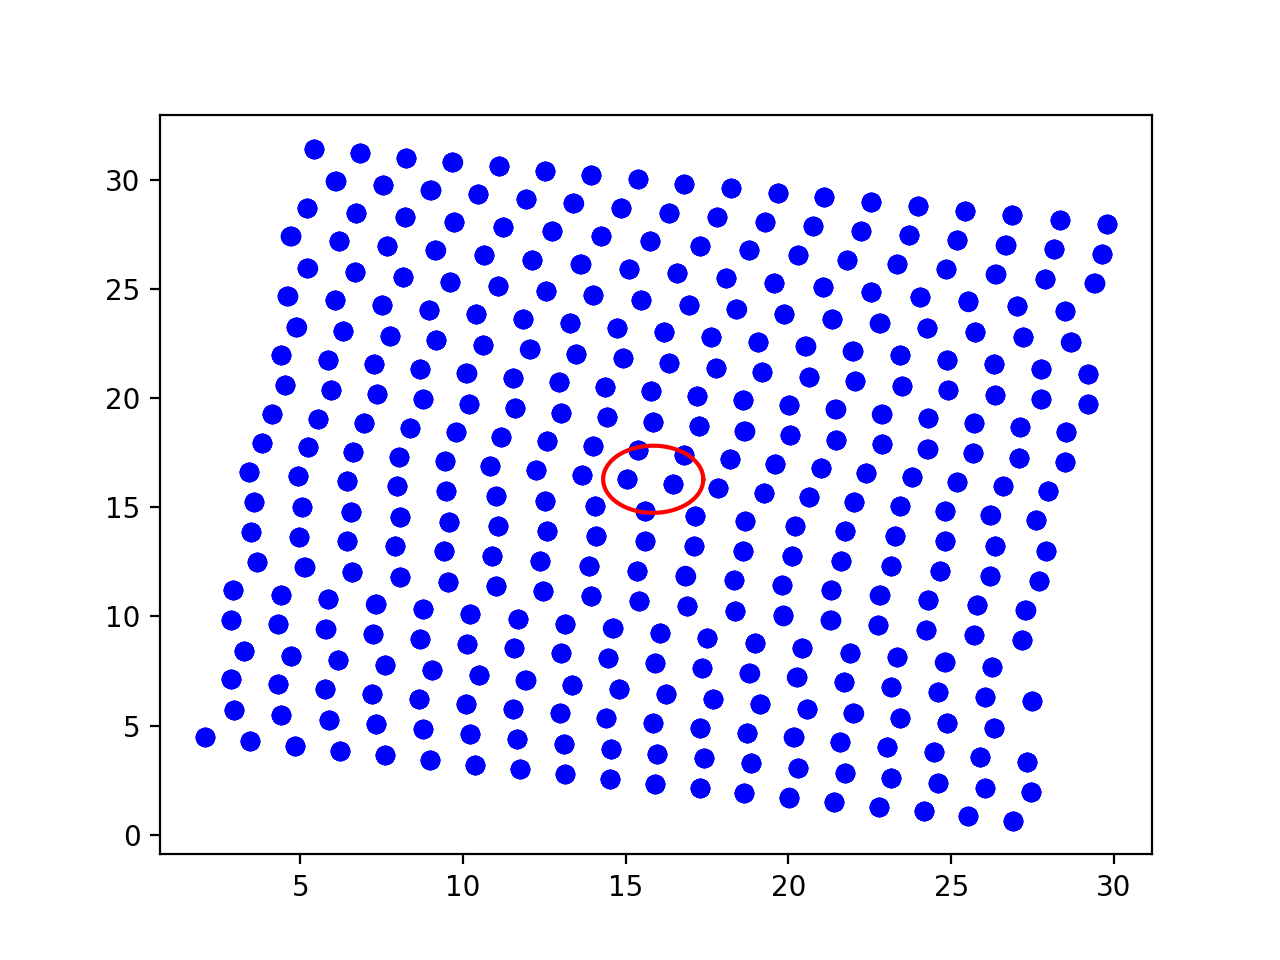

<IPython.core.display.Javascript object>


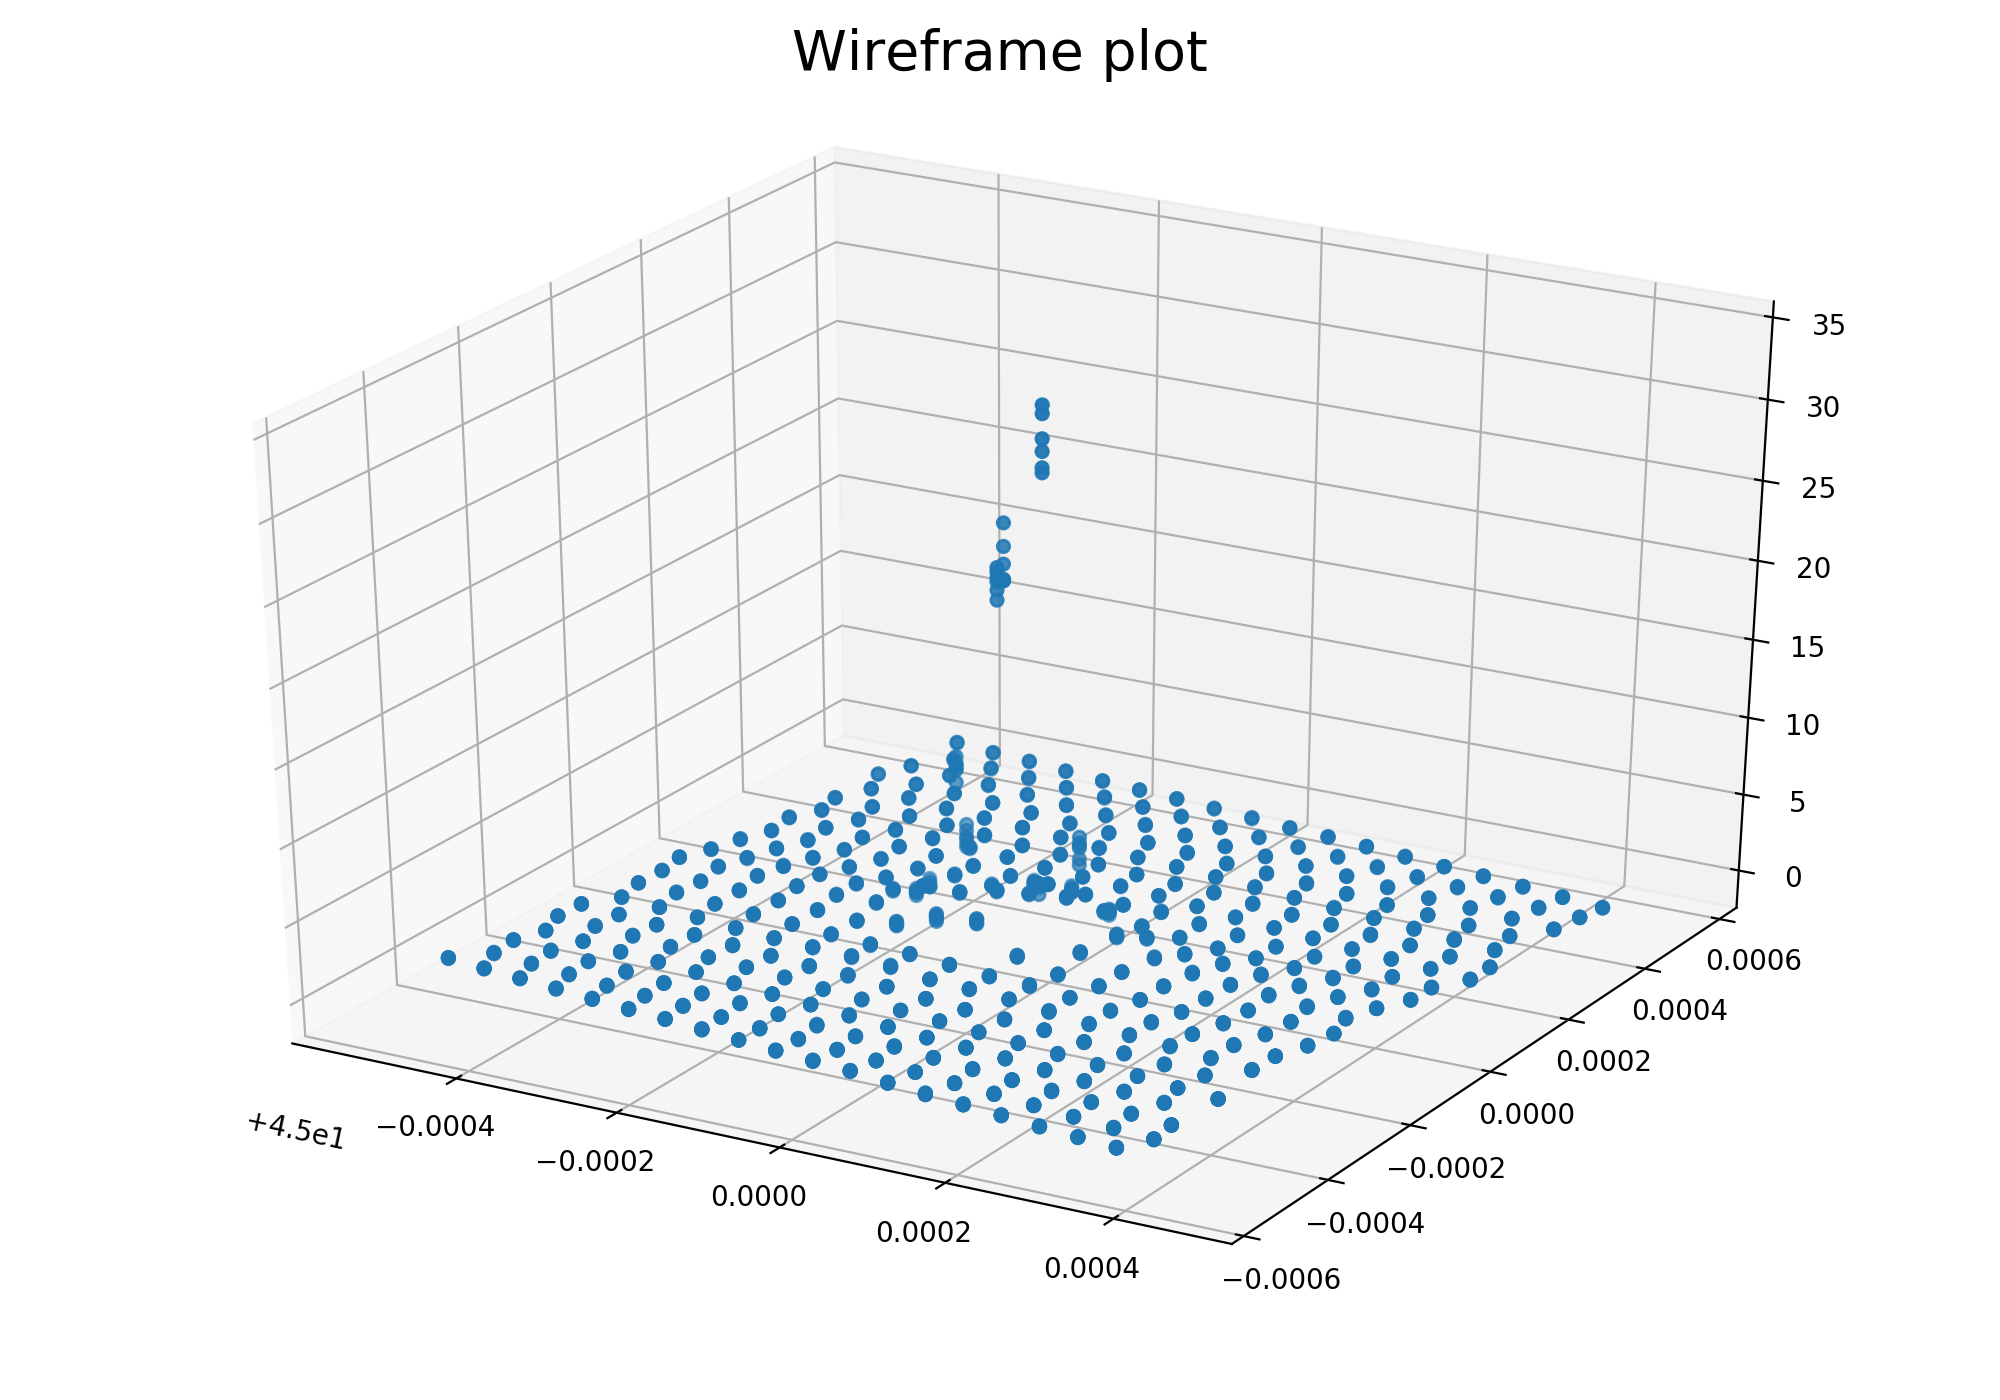

<IPython.core.display.Javascript object>


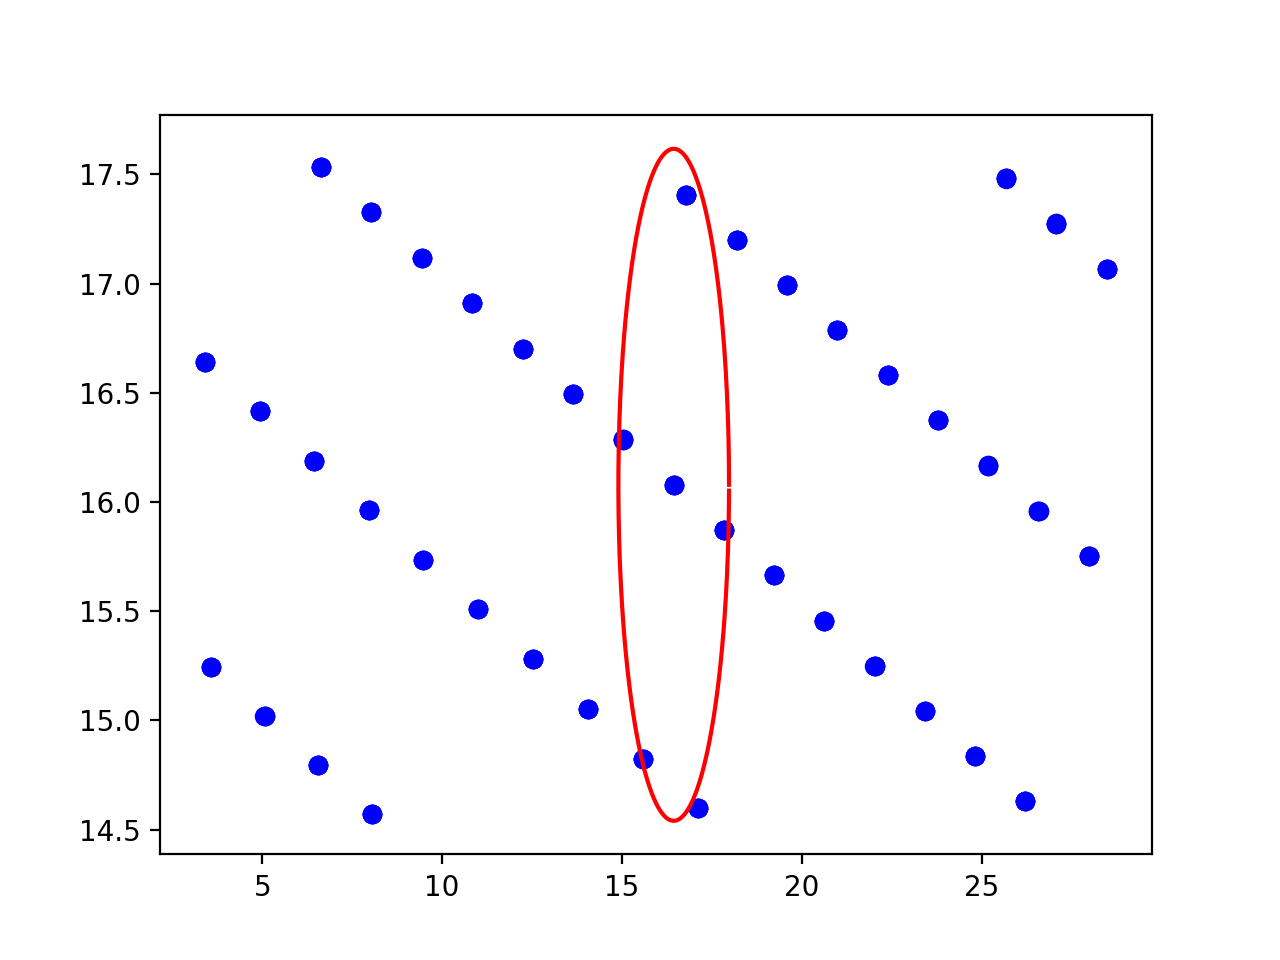

<IPython.core.display.Javascript object>


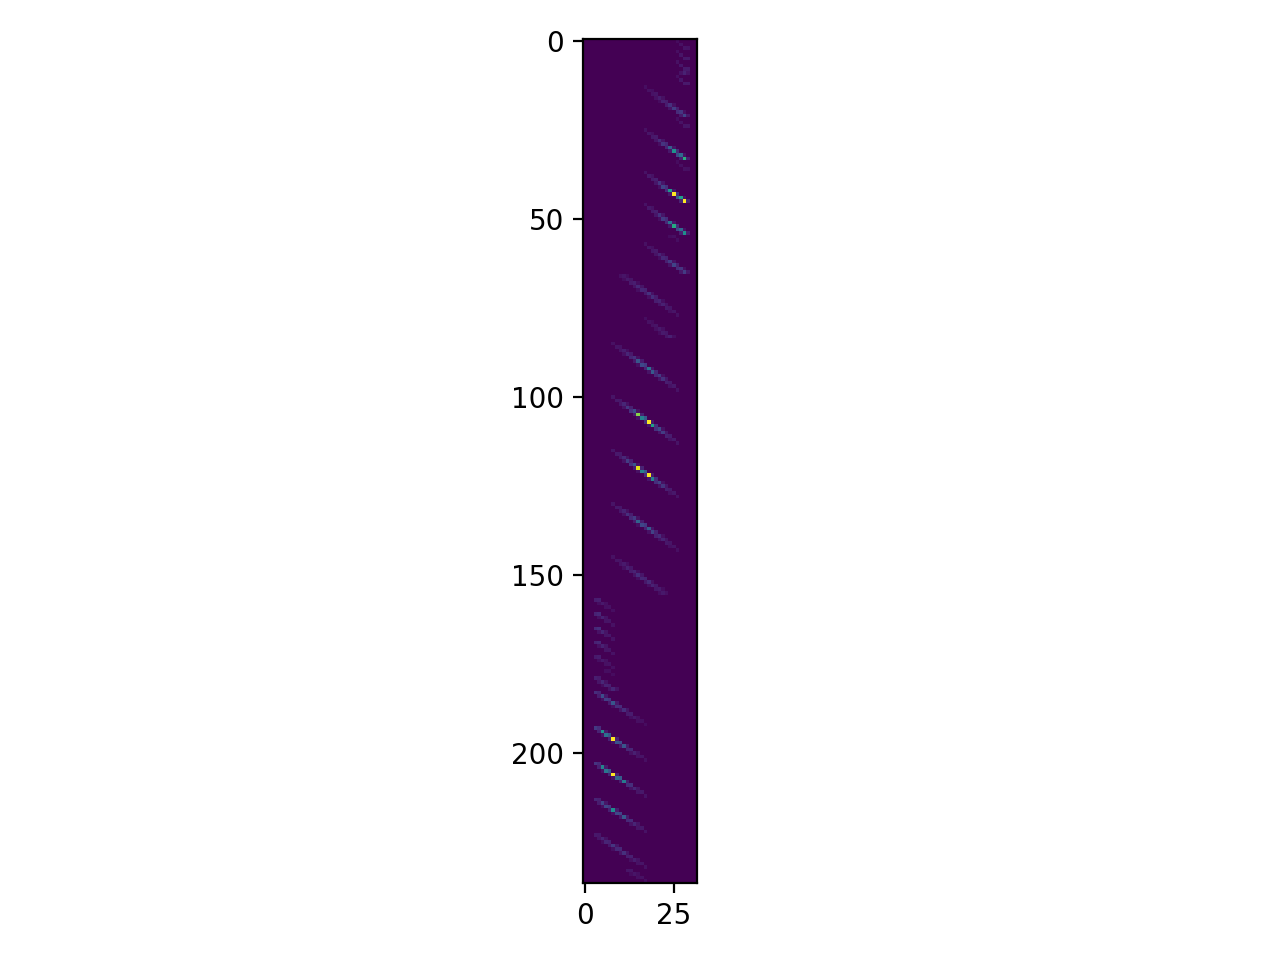

In [15]:
# Loop over output cube building the cube slice by slice
for k in range(thisdim_out[2]):
    # First pass cut: trim to only stuff within rlim of this z location
    indexk=np.where(abs(cube_z-arr_zcoord[k]-0.5) <= rlim[2])
    nindexk = len(indexk[0])
    
    if (nindexk > 0):
        tempx=cube_x[indexk]
        tempy=cube_y[indexk]
        tempz=cube_z[indexk]
        tempf=master_flux[indexk]
        tempenum=master_expnum[indexk]
        temp_detx=master_detx[indexk]
        temp_dety=master_dety[indexk]
        temp_detlam=master_lam[indexk]

        # QA plot
        if thisdim_out[2]==1:
            plt.figure()
            plt.plot(tempx,tempy,'bo')
            circxcen=np.median(tempx)
            circycen=np.median(tempy)
            circphi=np.arange(360.)*np.pi/180.
            circx=circxcen+rlim[0]*np.cos(circphi)
            circy=circycen+rlim[1]*np.sin(circphi)
            plt.plot(circx,circy,'r')
            plt.show()
            
            # make wireframe plot
            from mpl_toolkits.mplot3d import Axes3D

            fig = plt.figure(figsize=(10,7))
            ax = fig.gca(projection='3d')
            ax.scatter(master_ra[indexk], master_dec[indexk], tempf)
            ax.tick_params(axis='both',labelsize=10)
            plt.suptitle('Wireframe plot',fontsize=20)
            plt.tight_layout(rect=[0, 0.03, 1, 0.98])
            plt.show()
            
        # Loop over output image, building the image row by row
        for j in range(thisdim_out[1]):
            # Second pass cut: trim to only stuff within rlim of this y location
            indexj=np.where(abs(tempy-arr_ycoord[j]) <= rlim[1])
            nindexj = len(indexj[0])

            # If nothing makes the cut, do nothing.  Otherwise
            # build the row
            if (nindexj > 0):
                tempx2=tempx[indexj]
                tempy2=tempy[indexj]
                tempz2=tempz[indexj]
                tempf2=tempf[indexj]
                tempenum2=tempenum[indexj]
                temp2_detx=temp_detx[indexj]
                temp2_dety=temp_dety[indexj]
                temp2_detlam=temp_detlam[indexj]
                
                if (thisdim_out[2]==1) & (j == thisdim_out[1]/2):
                    plt.figure()
                    plt.plot(tempx2,tempy2,'bo')
                    circxcen=np.median(tempx2)
                    circycen=np.median(tempy2)
                    circphi=np.arange(360.)*np.pi/180.
                    circx=circxcen+rlim[0]*np.cos(circphi)
                    circy=circycen+rlim[1]*np.sin(circphi)
                    plt.plot(circx,circy,'r')
                    plt.show()
                    
                # Now do a 1d build within this slice, looping over input points
                arr_weights=np.zeros((nindexj,thisdim_out[0]))

                for q in range(nindexj):
                    arr_radius=(rlim[0]+1)*np.ones(thisdim_out[0])
                    arr_sradius=(rlim[0]+1)*np.ones(thisdim_out[0])

                    # Which output pixels are affected by input points, i.e.
                    # within rlim of this x location?
                    # Don't go outside output array boundaries
                    # sel = np.where((np.floor(tempx2-rlim[0]) > 0) & (np.ceil(tempx2+rlim[0]) < thisdim_out[0]-1))

                    # Number of points within box
                    nbox=len(arr_xcoord)

                    # Calculate physical spatial radius for ROI determination
                    rx=arr_xcoord-tempx2[q]
                    ry=arr_ycoord[j]-tempy2[q]
                    arr_radius=np.sqrt(rx**2 + np.ones(nbox)*ry**2)

                    # Determine points within the final circular ROI
                    tocalc=np.where(arr_radius <= rlim[0])
                    ncalc = len(tocalc[0])

                    # Squashed radii for weights
                    srx=rx/xsquash
                    sry=ry/ysquash
                    srz=(arr_zcoord[k]-tempz2[q]+0.5)/zsquash


                    # Combine normalized radii inside ROI
                    arr_sradius = np.sqrt( (srx**2) + np.ones(nbox)* sry**2 + np.ones(nbox)* srz**2  )

                    # Ensure no divide by zero
                    if (ncalc > 0):
                        if (wtype == 0):
                            arr_weights[q,tocalc]=1.
                        elif (wtype == 1):
                            arr_weights[q,tocalc]=1./arr_sradius[tocalc]
                        elif (wtype == 2):
                            arr_weights[q,tocalc]=1./arr_sradius[tocalc]**2
                        elif (wtype == 3):
                            arr_weights[q,tocalc]=np.exp(-0.5/expsig**2*arr_sradius[tocalc]**2)
                        elif (wtype == 4):
                            arr_weights[q,tocalc]=1./arr_sradius[tocalc]**4
                
                if (thisdim_out[2]==1) & (j == thisdim_out[1]/2):
                    plt.figure()
                    plt.imshow(arr_weights,vmin=0,vmax=10)
                    plt.tight_layout()
                
                # Normalization matrix
                if (nindexj == 1):
                    matr_norm=arr_weights
                else:
                    matr_norm = np.sum(arr_weights,0)

                # Flag where the normalization matrix is zero; there is no good datum here
                nodata=np.where(matr_norm == 0)
                nnodata = len(nodata[0])
                gooddata = np.where(matr_norm != 0)
                ngood = len(gooddata[0])
                # Mark good locations in output mask
                if (ngood != 0):
                    maskcube[gooddata,j,k]=0

                # We don't want to divide by zero where there is no data# set the normalization
                # matrix to 1 in these cases
                if (nnodata > 0):
                    matr_norm[nodata]=1.

                # Apply the weights to calculate the output flux in this row
                frow=np.zeros(thisdim_out[0])
                for q in range (nindexj):
                    alpha=arr_weights[q,:]/matr_norm
                    frow+=tempf2[q]*alpha

                # Put the row into the final cube
                fcube[:,j,k]=frow*scale

<IPython.core.display.Javascript object>


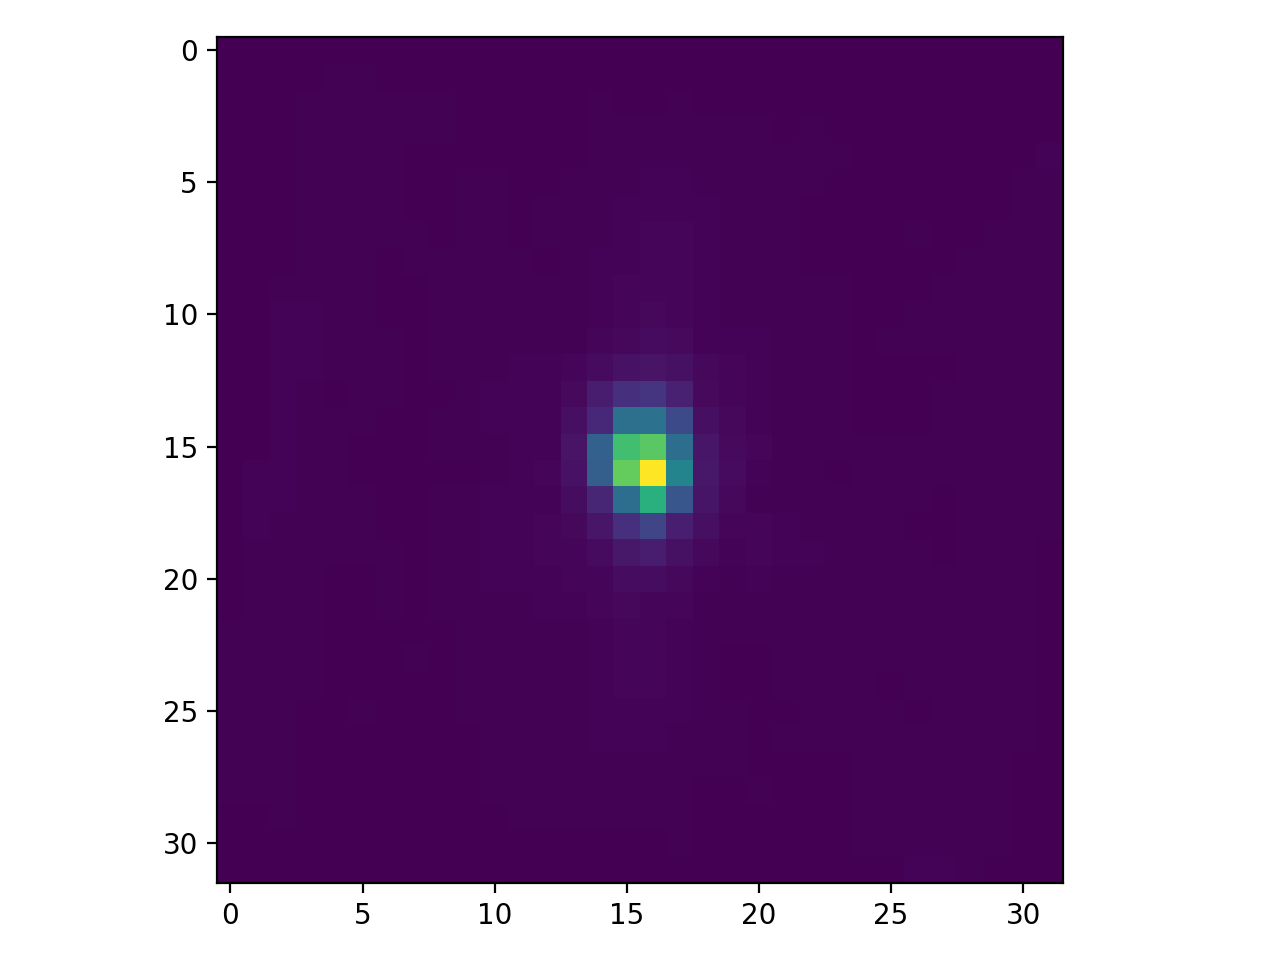

<IPython.core.display.Javascript object>


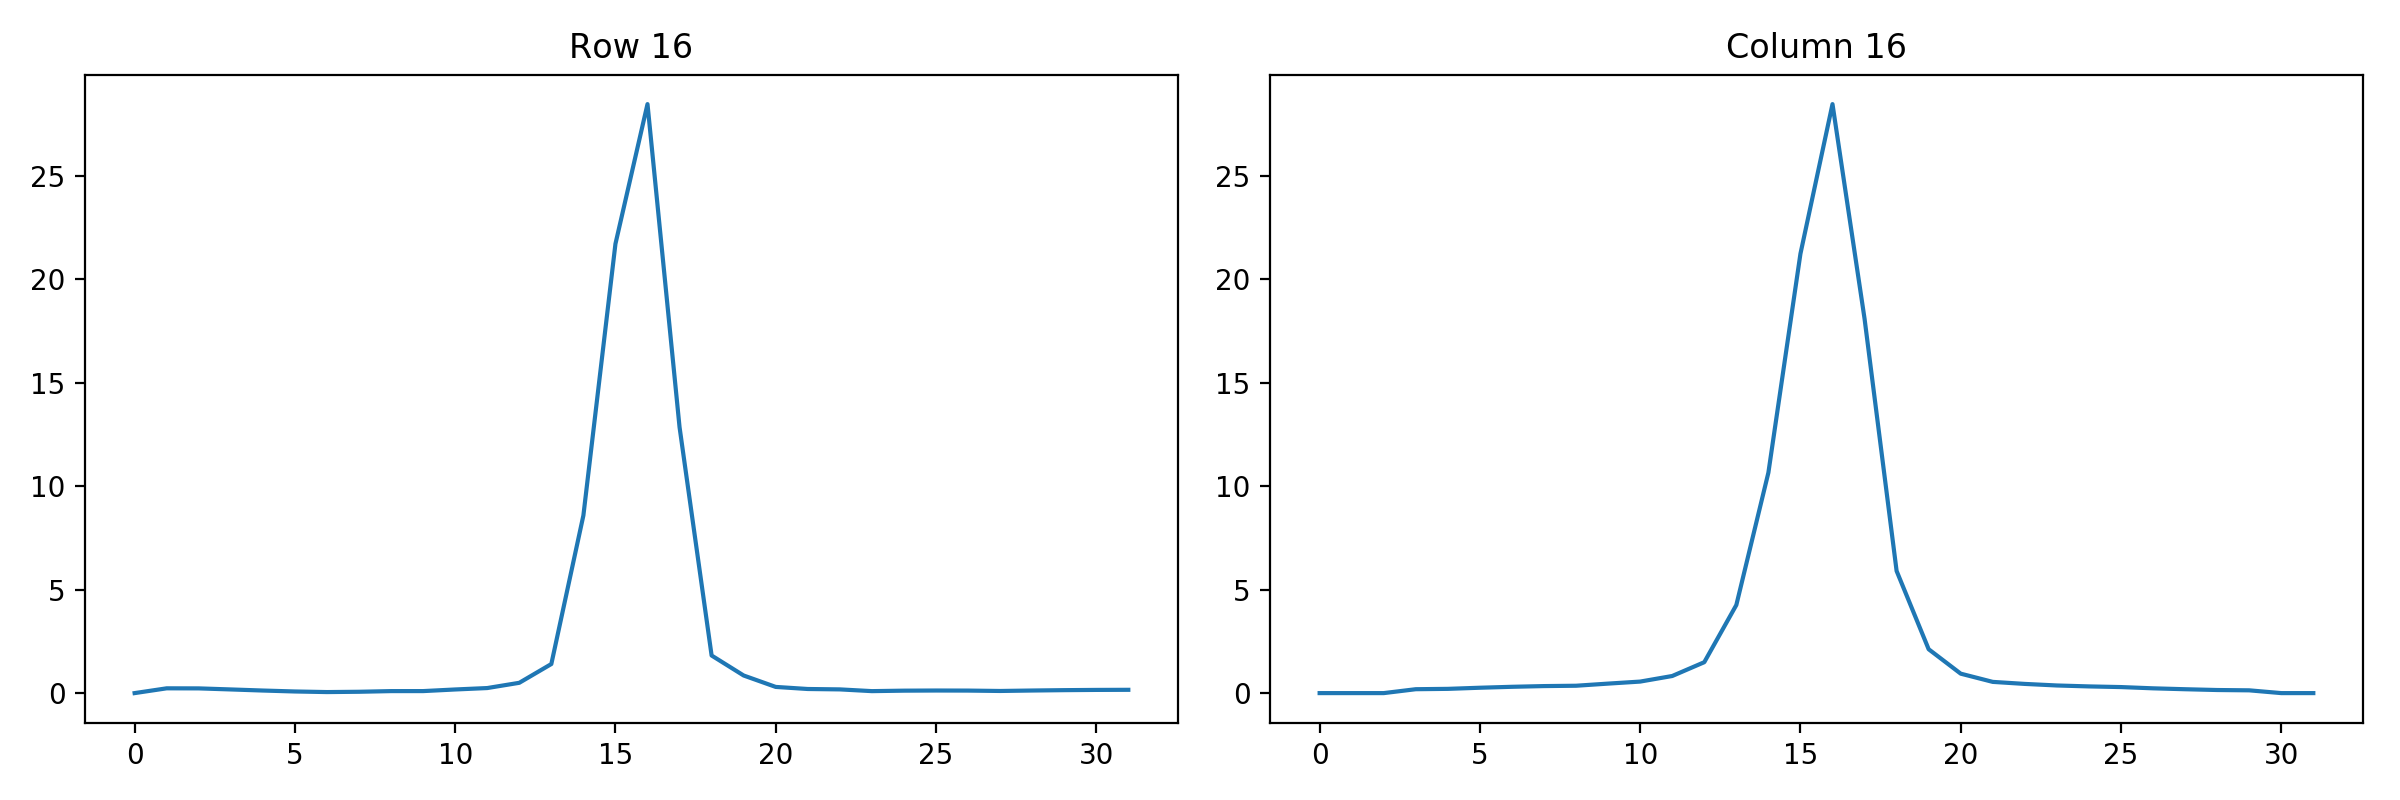

In [16]:
plt.figure()
plt.imshow(fcube[:,:,0])
plt.tight_layout()

fig,axs=plt.subplots(1,2,figsize=(12,4))
axs[0].plot(fcube[16,:,0])
axs[0].set_title('Row 16')
axs[1].plot(fcube[:,16,0])
axs[1].set_title('Column 16')
plt.tight_layout()

<IPython.core.display.Javascript object>


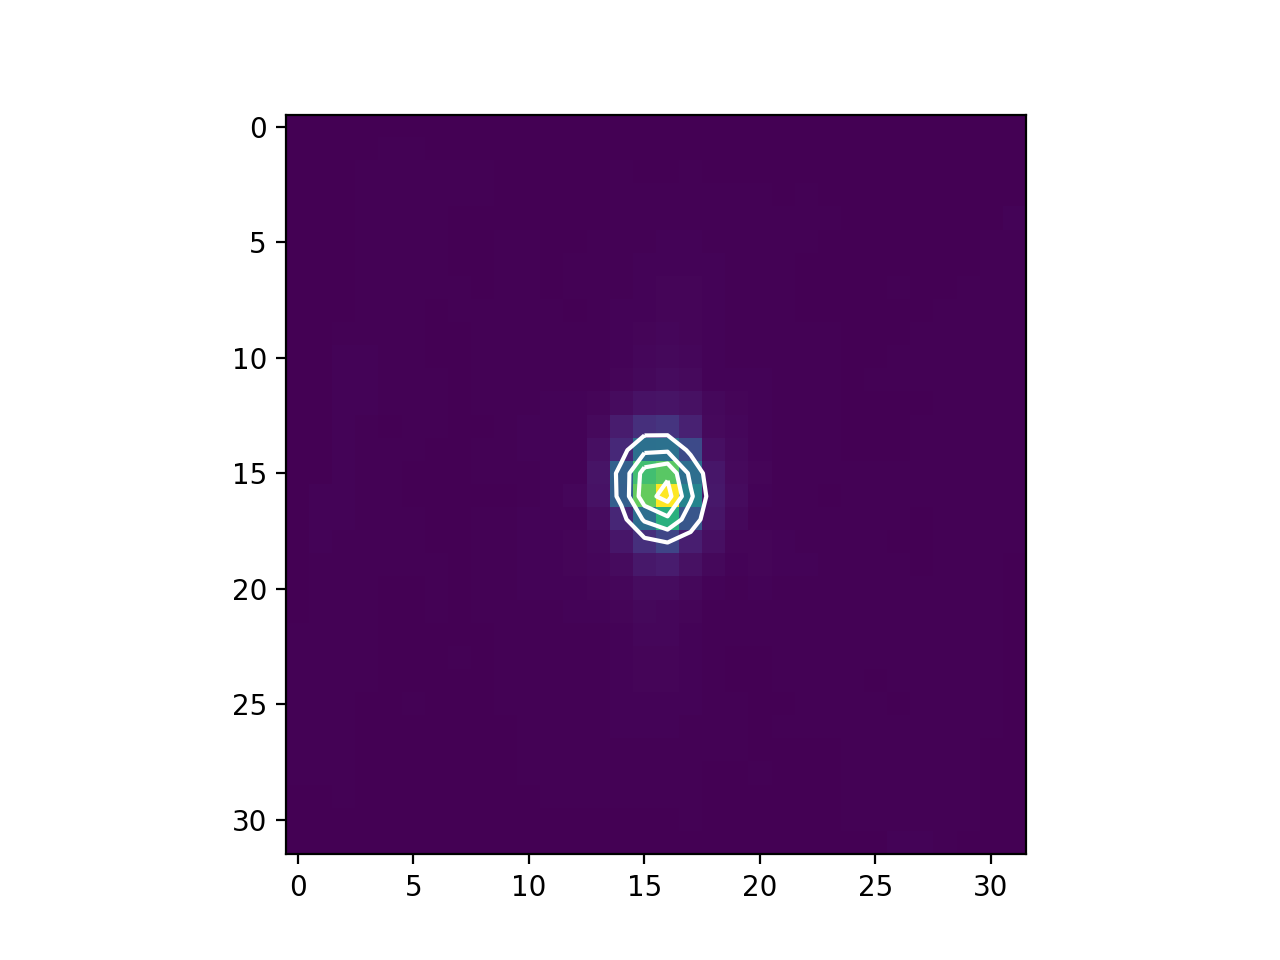

<IPython.core.display.Javascript object>


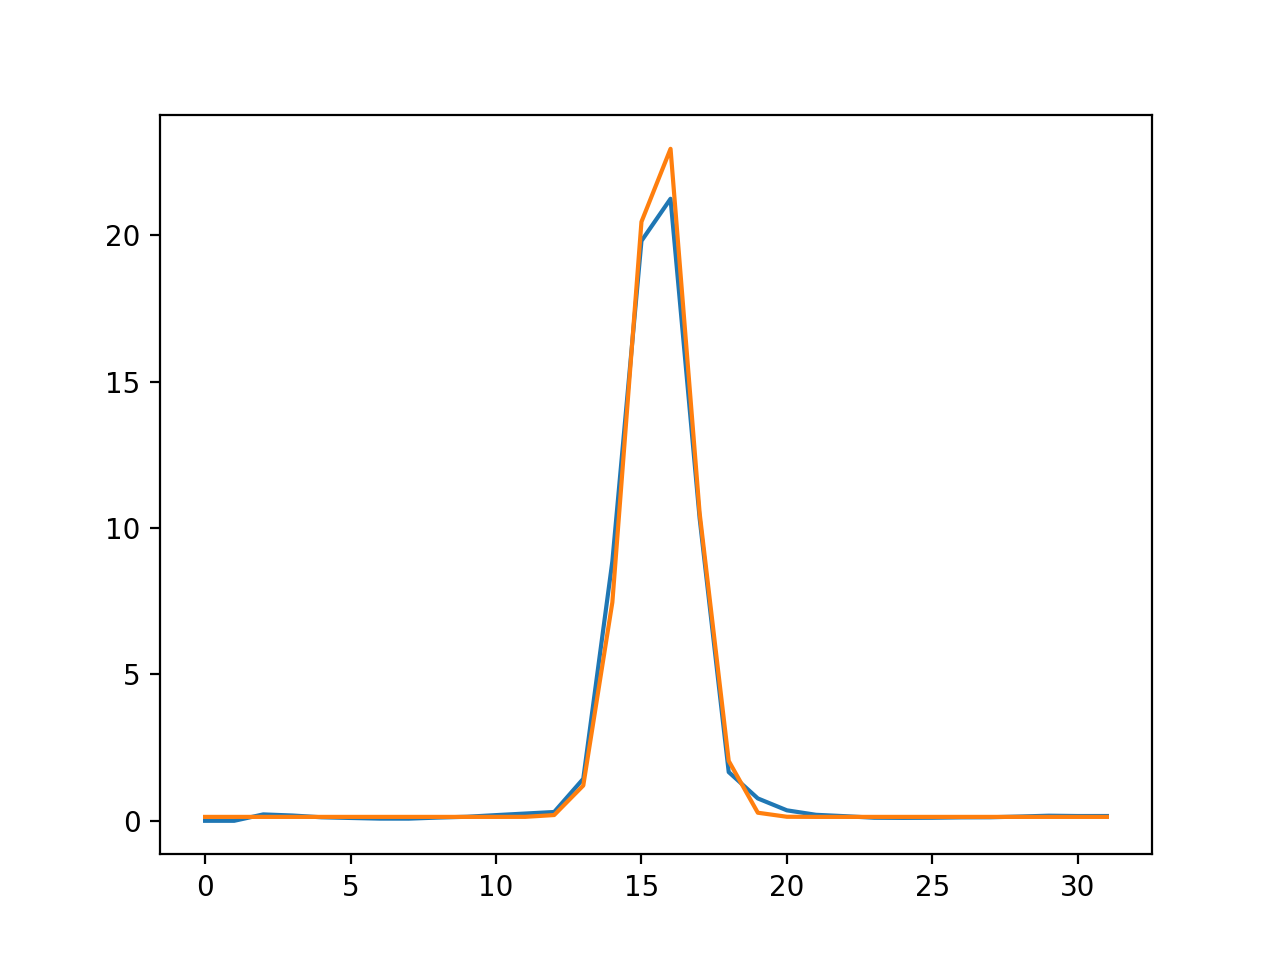

Wavelength (micron): 5.34736591254
X FWHM (arcsec): 0.319
Y FWHM (arcsec): 0.406


In [17]:
if islice is not None:
    # Recover gaussian FWHM
    x = np.arange(fcube.shape[0])
    y = np.arange(fcube.shape[1])
    x, y = np.meshgrid(x, y)

    initial_guess = (3,fcube.shape[0]/2,fcube.shape[1]/2,1,1,0,0)

    popt, pcov = curve_fit(twoD_Gaussian_ravel, (x, y), fcube[:,:,0].ravel(), p0=initial_guess)
    data_fitted = twoD_Gaussian_noravel((x, y), *popt)

    plt.figure()
    plt.imshow(fcube[:,:,0])
    plt.contour(x, y, data_fitted, 4, colors='w')
    plt.show()

    plt.figure()
    plt.plot(fcube[:,:,0][15,:])
    plt.plot(data_fitted[15,:])
    plt.show()

    fwhmx=np.round(popt[3]*2.355*ps_x*1e3)/1e3
    fwhmy=np.round(popt[4]*2.355*ps_y*1e3)/1e3
    print('Wavelength (micron): {}'.format(islice*ps_z+min(baselambda)))
    print('X FWHM (arcsec): {}'.format(fwhmx))
    print('Y FWHM (arcsec): {}'.format(fwhmy))

In [18]:
if write_fits_file:
    # Write file
    hdu0 = fits.PrimaryHDU()
    hdu1 = fits.ImageHDU(fcube.transpose(2,1,0))
    cdarr=np.zeros((2,2))
    cdarr[0,0]=2.77778e-4*ps_x
    cdarr[1,1]=2.77778e-4*ps_y
    # Make astrometry solution, don't forget to put xcen/ycen in
    # 1-indexed FITS convention
    hdu1.header['CD1_1'] = cdarr[0,0]
    hdu1.header['CD1_2'] = 0
    hdu1.header['CD1_3'] = 0
    hdu1.header['CD2_1'] = 0
    hdu1.header['CD2_2'] = 0
    hdu1.header['CD2_2'] = cdarr[1,1]
    hdu1.header['CD3_1'] = 0
    hdu1.header['CD3_2'] = 0
    hdu1.header['CD3_3'] = ps_z
    hdu1.header['CRPIX1'] = xcen+1
    hdu1.header['CRPIX2'] = ycen+1
    hdu1.header['CRPIX3'] = 1
    hdu1.header['CRVAL1'] = racen
    hdu1.header['CRVAL2'] = decen
    hdu1.header['CRVAL3'] = lamstart
    hdu1.header['CDELT3'] = ps_z
    hdu1.header['CUNIT3'] = 'um'
    hdu1.header['CTYPE3'] = 'WAVE'

    hdulist = fits.HDUList([hdu0,hdu1])
    if fcube.shape[2] == 1:
        hdulist.writeto(outslice,overwrite=True)
    elif fcube.shape[2] > 1:
        hdulist.writeto(outcube,overwrite=True)